In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import holidays
from datetime import timedelta
from statsmodels.tsa.seasonal import seasonal_decompose

# 1 Data Loading and Overview

In [2]:
df = pd.read_csv("../data/raw/df.csv", index_col=0)

In [3]:
# Show data
display(df.head(3))
display(df.tail(3))

,date,category_id,sku_id,sales_price,sales_quantity
78161,2016-11-25,7,1108,457.6,1.0
81079,2016-11-18,7,2999,470.6,1.0
81177,2016-11-18,7,1428,717.6,1.0


,date,category_id,sku_id,sales_price,sales_quantity
20778611,2020-10-14,7,723588,401.7,3.0
20779790,2020-10-17,7,792124,778.7,1.0
20794630,2020-10-23,7,798049,219.7,1.0


**Features description:**
- date — Date of sale.
- sku_id — Stock Keeping Unit; unique identifier for each product.
- sales_quantity — Number of units sold on that date.
- sales_price — Average sales price per unit on that date.
- category_id — Category code of the product.

In [4]:
print("Shape:", df.shape)
print("DataTypes:")
print(df.dtypes)

Shape: (226486, 5)
DataTypes:
date               object
category_id         int64
sku_id              int64
sales_price       float64
sales_quantity    float64
dtype: object


In [5]:
print("Unique values per column:")
print(df.nunique())

Unique values per column:
date              1420
category_id          3
sku_id            1059
sales_price       1373
sales_quantity     979
dtype: int64


In [6]:
print("Number of SKU per category:")
print(df.groupby("category_id")["sku_id"].nunique())

Number of SKU per category:
category_id
7     730
17    299
23     30
Name: sku_id, dtype: int64


In [7]:
# Date to datatime format
df["date"] = pd.to_datetime(df["date"])

# Sort by date and reset index
df = df.sort_values("date").reset_index(drop=True)

In [8]:
print("Min date:", df["date"].min())
print("Max date:", df["date"].max())

Min date: 2016-11-18 00:00:00
Max date: 2020-10-31 00:00:00


In [9]:
# Extra year feature
df['year'] = df['date'].dt.year
df['year'].value_counts().sort_index()

year
2016     5665
2017    49403
2018    56728
2019    55629
2020    59061
Name: count, dtype: int64

# 2 Check Data Quality 

In [10]:
print("Missing values:")
df.isnull().sum()

Missing values:


date              0
category_id       0
sku_id            0
sales_price       0
sales_quantity    0
year              0
dtype: int64

In [11]:
print("Duplicate rows:", df.duplicated().sum())
print("Unique dates:", df['date'].nunique())

Duplicate rows: 0
Unique dates: 1420


In [12]:
# Check if there are duplicates: same sku for same day
if df.groupby(["date", "sku_id"])["sku_id"].count().max() < 2:
    print("There are no duplicates for same date.")
else:
    print("Chech data for duplicates (date/sku)")

There are no duplicates for same date.


In [13]:
# Check if there are missing dates for whole categories
def print_missing_dates_by_category(df):
    min_date = df["date"].min()
    max_date = df["date"].max()
    all_dates = pd.date_range(min_date, max_date, freq='D')
    categories = sorted(df['category_id'].unique())
    
    for cat in categories:
        cat_dates = pd.to_datetime(df.loc[df['category_id'] == cat, 'date'].unique())
        missing_dates = sorted(set(all_dates) - set(cat_dates))
        # Convert to string format 'YYYY-MM-DD'
        missing_dates_str = [d.strftime('%Y-%m-%d') for d in missing_dates]
        print(f"Category {cat}: {len(missing_dates_str)} missing dates")
        if missing_dates_str:
            print(missing_dates_str)
        else:
            print("No missing dates.")
        print()

# Usage
print_missing_dates_by_category(df)

Category 7: 25 missing dates
['2019-06-04', '2019-07-16', '2019-09-03', '2019-09-04', '2019-09-05', '2019-09-06', '2019-09-07', '2019-09-08', '2019-09-09', '2019-09-10', '2019-09-11', '2019-09-12', '2019-09-13', '2019-09-14', '2019-09-15', '2019-09-16', '2019-09-17', '2019-09-18', '2019-09-19', '2019-09-20', '2019-09-21', '2019-09-22', '2019-09-23', '2019-09-24', '2019-09-25']

Category 17: 24 missing dates
['2019-06-04', '2019-09-03', '2019-09-04', '2019-09-05', '2019-09-06', '2019-09-07', '2019-09-08', '2019-09-09', '2019-09-10', '2019-09-11', '2019-09-12', '2019-09-13', '2019-09-14', '2019-09-15', '2019-09-16', '2019-09-17', '2019-09-18', '2019-09-19', '2019-09-20', '2019-09-21', '2019-09-22', '2019-09-23', '2019-09-24', '2019-09-25']

Category 23: 24 missing dates
['2019-06-04', '2019-09-03', '2019-09-04', '2019-09-05', '2019-09-06', '2019-09-07', '2019-09-08', '2019-09-09', '2019-09-10', '2019-09-11', '2019-09-12', '2019-09-13', '2019-09-14', '2019-09-15', '2019-09-16', '2019-09-1

**We have 24 days missing in our dataset.**

# 3 Exploratory Data Analysis

## 3.1 Distributions of Sales Quantity and Price

### 3.1.1  Overall Distributions

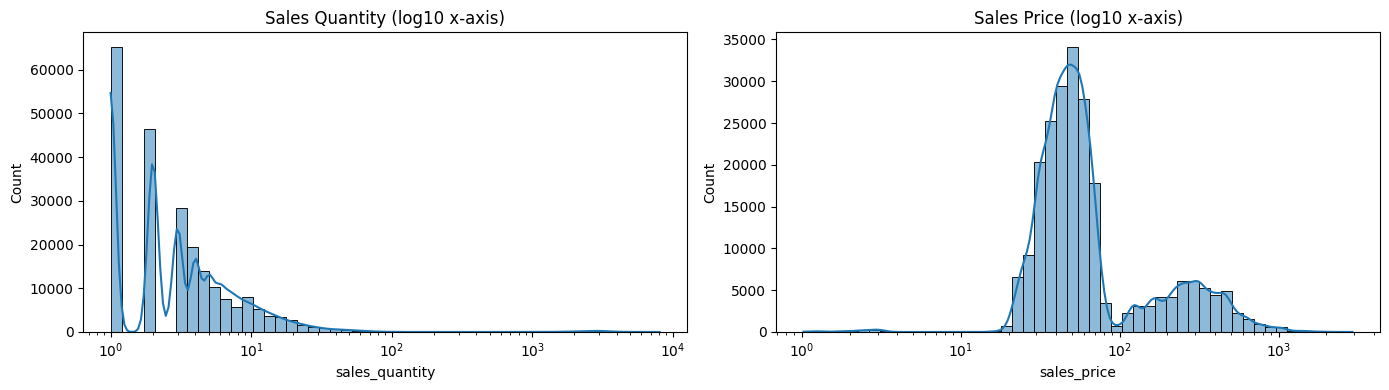

In [14]:
# log scale
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
sns.histplot(df['sales_quantity'], bins=50, kde=True, ax=axes[0], log_scale=(True, False))
axes[0].set_title('Sales Quantity (log10 x‑axis)')
sns.histplot(df['sales_price'], bins=50, kde=True, ax=axes[1], log_scale=(True, False))
axes[1].set_title('Sales Price (log10 x‑axis)')
plt.tight_layout(); plt.show()

In [15]:
print("Sales quantity bigger than 100:")
(df['sales_quantity'] > 100).value_counts(normalize=True) * 100

Sales quantity bigger than 100:


sales_quantity
False    99.538603
True      0.461397
Name: proportion, dtype: float64

**Sales Quantity:**
The distribution is extremely right-skewed: the vast majority of transactions involve small quantities (mostly 1–5 units), while only a few transactions involve large quantities (with just 0.5% of transactions exceeding 100 items).

**Sales Price:**
The distribution appears to be a mixture of two or more distributions (different product categories have different price ranges).

### 3.1.2  By Category

In [16]:
# Create stable pallete
categories = sorted(df['category_id'].unique())
colors = sns.color_palette('Set1', n_colors=len(categories))
palette_dict = dict(zip(categories, colors))

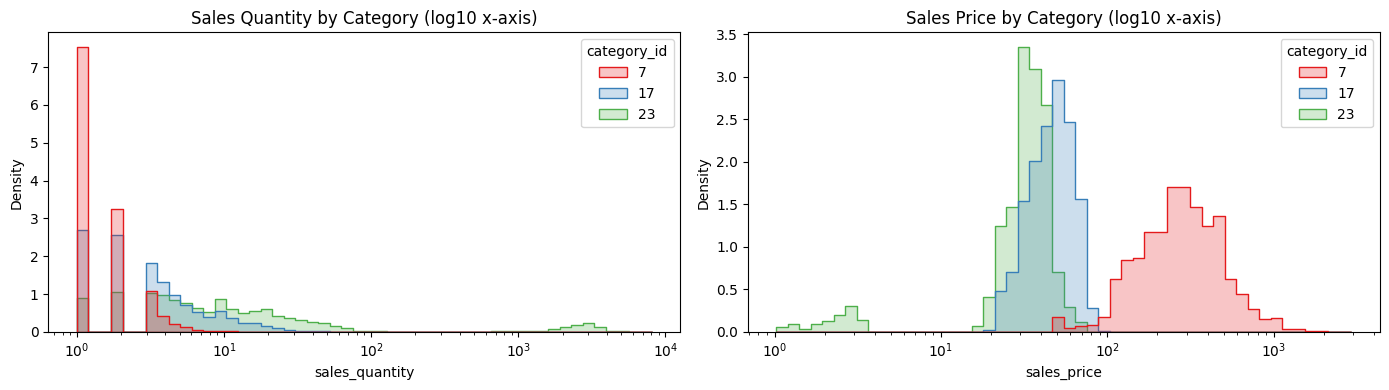

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

sns.histplot(
    df, x='sales_quantity', hue='category_id',
    bins=50, kde=False, log_scale=(True, False),
    element='step', stat='density', common_norm=False,
    ax=axes[0], palette=palette_dict, hue_order=categories
)
axes[0].set_title('Sales Quantity by Category (log10 x-axis)')

sns.histplot(
    df, x='sales_price', hue='category_id',
    bins=50, kde=False, log_scale=(True, False),
    element='step', stat='density', common_norm=False,
    ax=axes[1], palette=palette_dict, hue_order=categories
)
axes[1].set_title('Sales Price by Category (log10 x-axis)')

plt.tight_layout()
plt.show()

**Sales Quantity:** All categories are similarly right-skewed, but the shape and scale of the tail varies. Category 23 generally has higher quantities (with more outliers), while Category 7 lower.

**Sales Price:** Categories have distinct price bands. In 95% of cases Category 7 has prices over 100, prices less then 10 are Category 10.

## 3.2 Relationship Analysis

### 3.2.1 Sales Quantity vs Sales Price (Scatterplots)

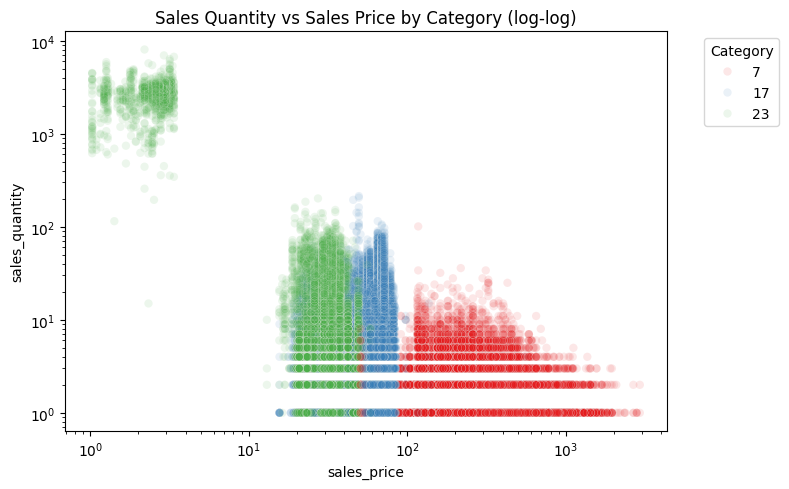

In [18]:
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=df,
    x='sales_price',
    y='sales_quantity',
    hue='category_id',
    palette=palette_dict,
    hue_order=categories,
    alpha=0.1
)
plt.xscale('log')
plt.yscale('log')
plt.title('Sales Quantity vs Sales Price by Category (log-log)')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Intermediate conclusions about Categories differences:**
- Category 23: high sales quantities and low to moderate prices.
- Category 17: moderate quantities and mid-range prices.
- Category 7: low sales quantities and higher prices.

Additionally we will check same plot but on SKU level (more clear):

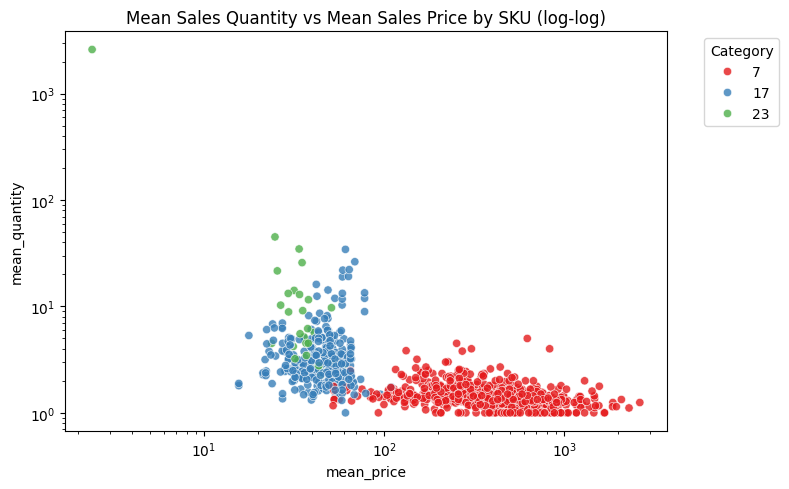

In [19]:
# Same plot but SKU level
df_sku = (
    df.groupby(['sku_id', 'category_id'])
      .agg(
          mean_price=('sales_price', 'mean'),
          mean_quantity=('sales_quantity', 'mean')
      )
      .reset_index()
)

plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=df_sku,
    x='mean_price',
    y='mean_quantity',
    hue='category_id',
    palette=palette_dict,
    hue_order=categories,
    alpha=0.8  # Usually higher for aggregated points
)
plt.xscale('log')
plt.yscale('log')
plt.title('Mean Sales Quantity vs Mean Sales Price by SKU (log-log)')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [20]:
# Select popular SKU
popular_sku_id = df_sku[df_sku.mean_quantity > 100].sku_id.iloc[0]
popular_sku_id

np.int64(64522)

**We can see that all points with quantity above 100 is the same SKU (64522)! (should we make an extra model for it?)**

### 3.2.2 Yearly Dynamics by Category (Boxplots, Stats)

In [21]:
def show_boxplot_and_statistics(column):
    
    # BoxPlot
    plt.figure(figsize=(12, 6))
    sns.boxplot(
        x='year',
        y=column,
        hue='category_id',
        data=df,
        showfliers=False,
        palette=palette_dict,
        hue_order=categories
    )
    plt.yscale('log')
    plt.title(f'{column} by Year and Category (log-scale)')
    plt.tight_layout()
    plt.show()
    

    # Common Stat
    stats = (
        df.groupby(['category_id', 'year'])[column]
          .agg(['mean', 'median', 'std'])
          .astype(int)
    )
    display(stats.T)

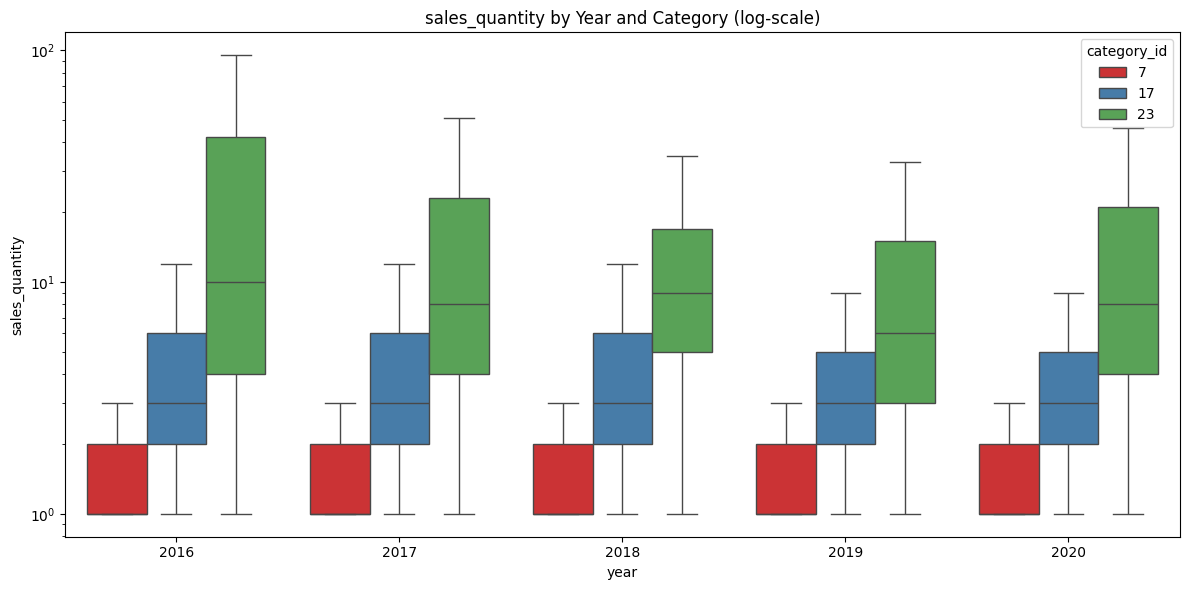

category_id   7                        17                       23            \
year        2016 2017 2018 2019 2020 2016 2017 2018 2019 2020 2016 2017 2018   
mean           1    1    1    1    1    5    4    4    4    5  282  358  341   
median         1    1    1    1    1    3    3    3    3    3   10    8    9   
std            2    1    1    1    1    5    4    5    5    7  734  973  956   

category_id            
year        2019 2020  
mean         149   16  
median         6    8  
std          576   19

In [22]:
show_boxplot_and_statistics('sales_quantity')

**Sales quantities for categories 7 and 17 are steady every year. For category 23, there are some ups and downs for CI, especially in 2018 and 2019.**

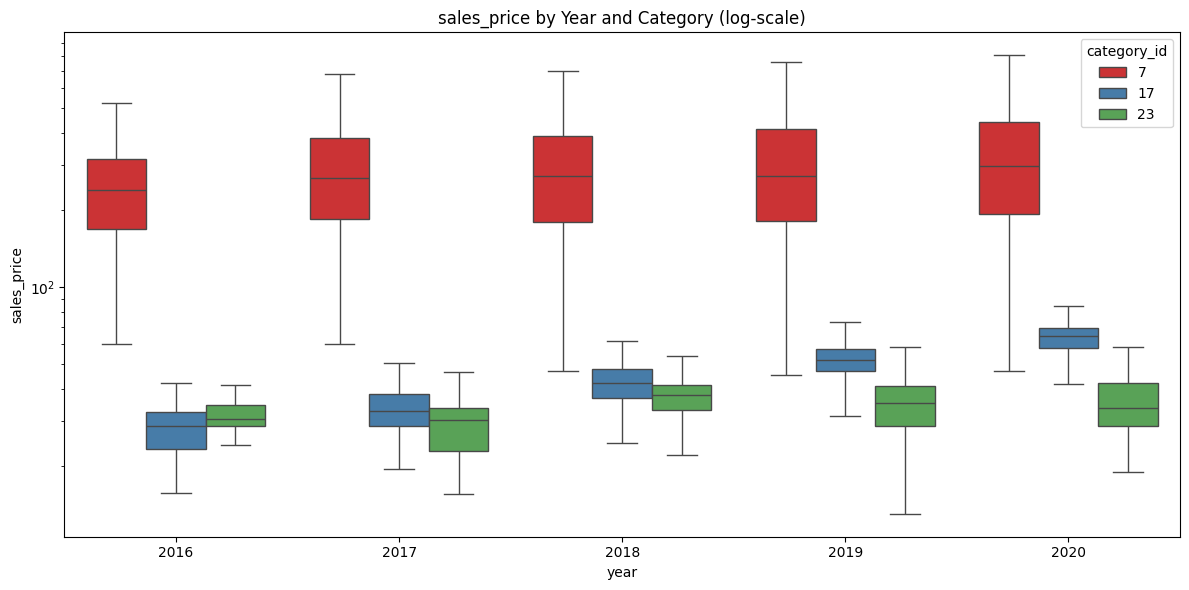

category_id   7                        17                       23            \
year        2016 2017 2018 2019 2020 2016 2017 2018 2019 2020 2016 2017 2018   
mean         266  303  307  321  339   28   33   42   52   63   28   26   34   
median       238  266  272  271  297   28   32   42   52   64   30   30   37   
std          147  183  189  206  218    5    6    7    8    8   11   11   12   

category_id            
year        2019 2020  
mean          33   35  
median        35   33  
std           11   10

In [23]:
show_boxplot_and_statistics('sales_price')

**Category 7:** Average and median sales prices steadily increase each year.

**Category 17:** Prices gradually rise over time.

**Category 23:** Prices are mostly stable from year to year.

## 3.3 SKU level stats

### 3.3.1 Min/Max ratio prices

sku_id
609715     1.000000
597017     1.000000
836236     1.000000
624099     1.000000
632396     1.000000
            ...    
575011     3.032143
605572     3.043810
64522      3.278481
718467     4.790146
749661    16.018307
Name: sales_price, Length: 1059, dtype: float64


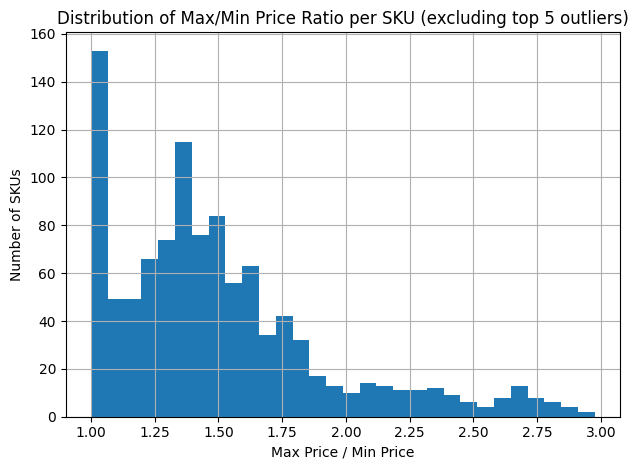

In [24]:
# Calculate the ratio of maximum to minimum price for each SKU
sku_price_max_min_ratio = (df.groupby('sku_id')['sales_price'].max() /\
                           df.groupby('sku_id')['sales_price'].min())
sku_price_max_min_ratio = sku_price_max_min_ratio.sort_values()
print(sku_price_max_min_ratio)

# Plot
sku_price_max_min_ratio.iloc[:-5].hist(bins=30)
plt.title("Distribution of Max/Min Price Ratio per SKU (excluding top 5 outliers)")
plt.xlabel("Max Price / Min Price")
plt.ylabel("Number of SKUs")
plt.tight_layout()
plt.show()

Same but for each year:

Year 2016 outliers


sku_id
550860    1.43
392584    1.43
597022    1.45
14035     1.48
619584    1.71
Name: max_min_ratio, dtype: float64

Year 2017 outliers


sku_id
374281    1.88
3923      1.90
435226    2.59
452279    2.63
64522     3.28
Name: max_min_ratio, dtype: float64

Year 2018 outliers


sku_id
700006    1.67
3052      1.70
437395    1.72
3923      1.76
505495    1.77
Name: max_min_ratio, dtype: float64

Year 2019 outliers


sku_id
350079    1.93
577080    1.98
726336    2.00
64522     2.84
718467    3.46
Name: max_min_ratio, dtype: float64

Year 2020 outliers


sku_id
812571     2.05
662920     2.57
748131     2.57
662913     2.57
749661    10.77
Name: max_min_ratio, dtype: float64

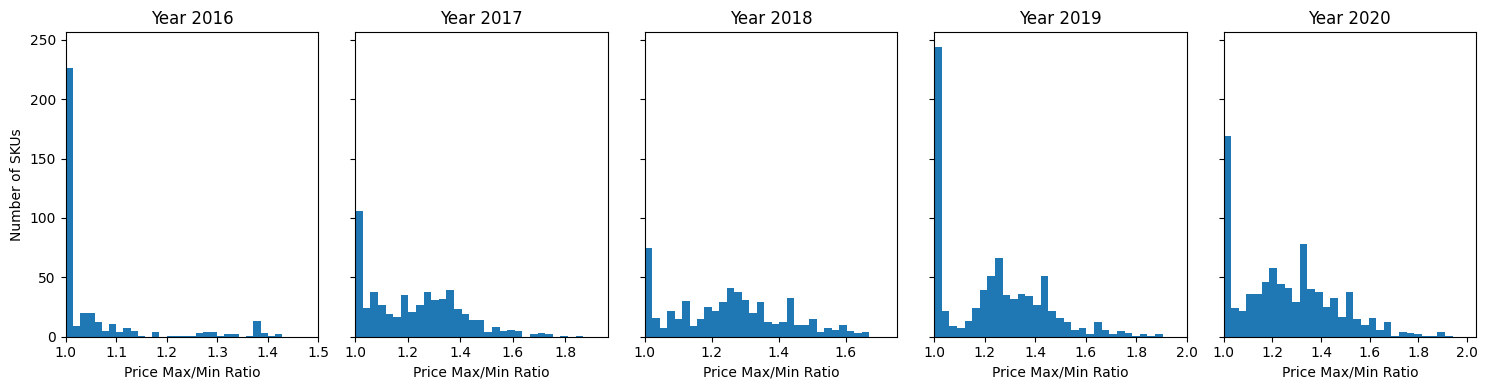

In [25]:
# Create an empty DataFrame to collect results
yearly_ratios = pd.DataFrame()

# Get all unique years
years = sorted(df['year'].unique())

for year in years:
    # For each year, group by sku_id and calculate price max/min ratio
    ratios = (
        df[df['year'] == year]
        .groupby('sku_id')['sales_price']
        .agg(['max', 'min'])
    )
    ratios = ratios[ratios['min'] > 0]  # avoid division by zero
    ratios['max_min_ratio'] = ratios['max'] / ratios['min']
    ratios['year'] = year
    yearly_ratios = pd.concat([yearly_ratios, ratios[['max_min_ratio', 'year']]])
    
# Now plot a histogram for each year in a row
n_years = len(years)
fig, axes = plt.subplots(1, n_years, figsize=(3 * n_years, 4), sharey=True)

for i, year in enumerate(years):
    ax = axes[i] if n_years > 1 else axes
    # Exclude top 10 outliers
    yearly_data = yearly_ratios[yearly_ratios['year'] == year]['max_min_ratio'].sort_values()
    outliers = yearly_data.iloc[-5:].round(2)
    print(f"Year {year} outliers")
    display(outliers)
    yearly_data = yearly_data.iloc[:-5]
    ax.hist(yearly_data, bins=30)
    ax.set_title(f"Year {year}")
    ax.set_xlabel('Price Max/Min Ratio')
    ax.set_xlim(1, yearly_data.max() * 1.05)
    if i == 0:
        ax.set_ylabel('Number of SKUs')
plt.tight_layout()
plt.show()

Most SKUs have stable prices within each year (usually not changing by more than 1.5x). Only a few unique SKUs each year show price jumps.

### 3.3.2 Coefficient of variation for SKU quantities

sku_id
753866    0.000000
824356    0.000000
655795    0.000000
788687    0.000000
490628    0.000000
            ...   
642225    1.334195
527090    1.353158
569768    1.411765
14016     1.489425
783066    2.042337
Name: sales_quantity, Length: 1036, dtype: float64

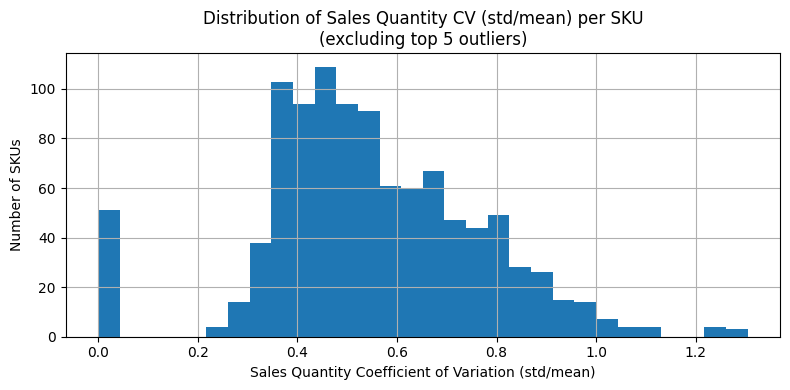

In [26]:
# Calculate the coefficient of variation (CV) for sales quantity per SKU
sku_quantity_mean = df.groupby('sku_id')['sales_quantity'].mean()
sku_quantity_std = df.groupby('sku_id')['sales_quantity'].std()
sku_quantity_cv = (sku_quantity_std / sku_quantity_mean).dropna()
sku_quantity_cv = sku_quantity_cv.sort_values()

display(sku_quantity_cv)

plt.figure(figsize=(8, 4))
# Exclude the 5 most extreme outliers for better visualization
sku_quantity_cv.iloc[:-5].hist(bins=30)
plt.title("Distribution of Sales Quantity CV (std/mean) per SKU\n(excluding top 5 outliers)")
plt.xlabel("Sales Quantity Coefficient of Variation (std/mean)")
plt.ylabel("Number of SKUs")
plt.tight_layout()
plt.show()

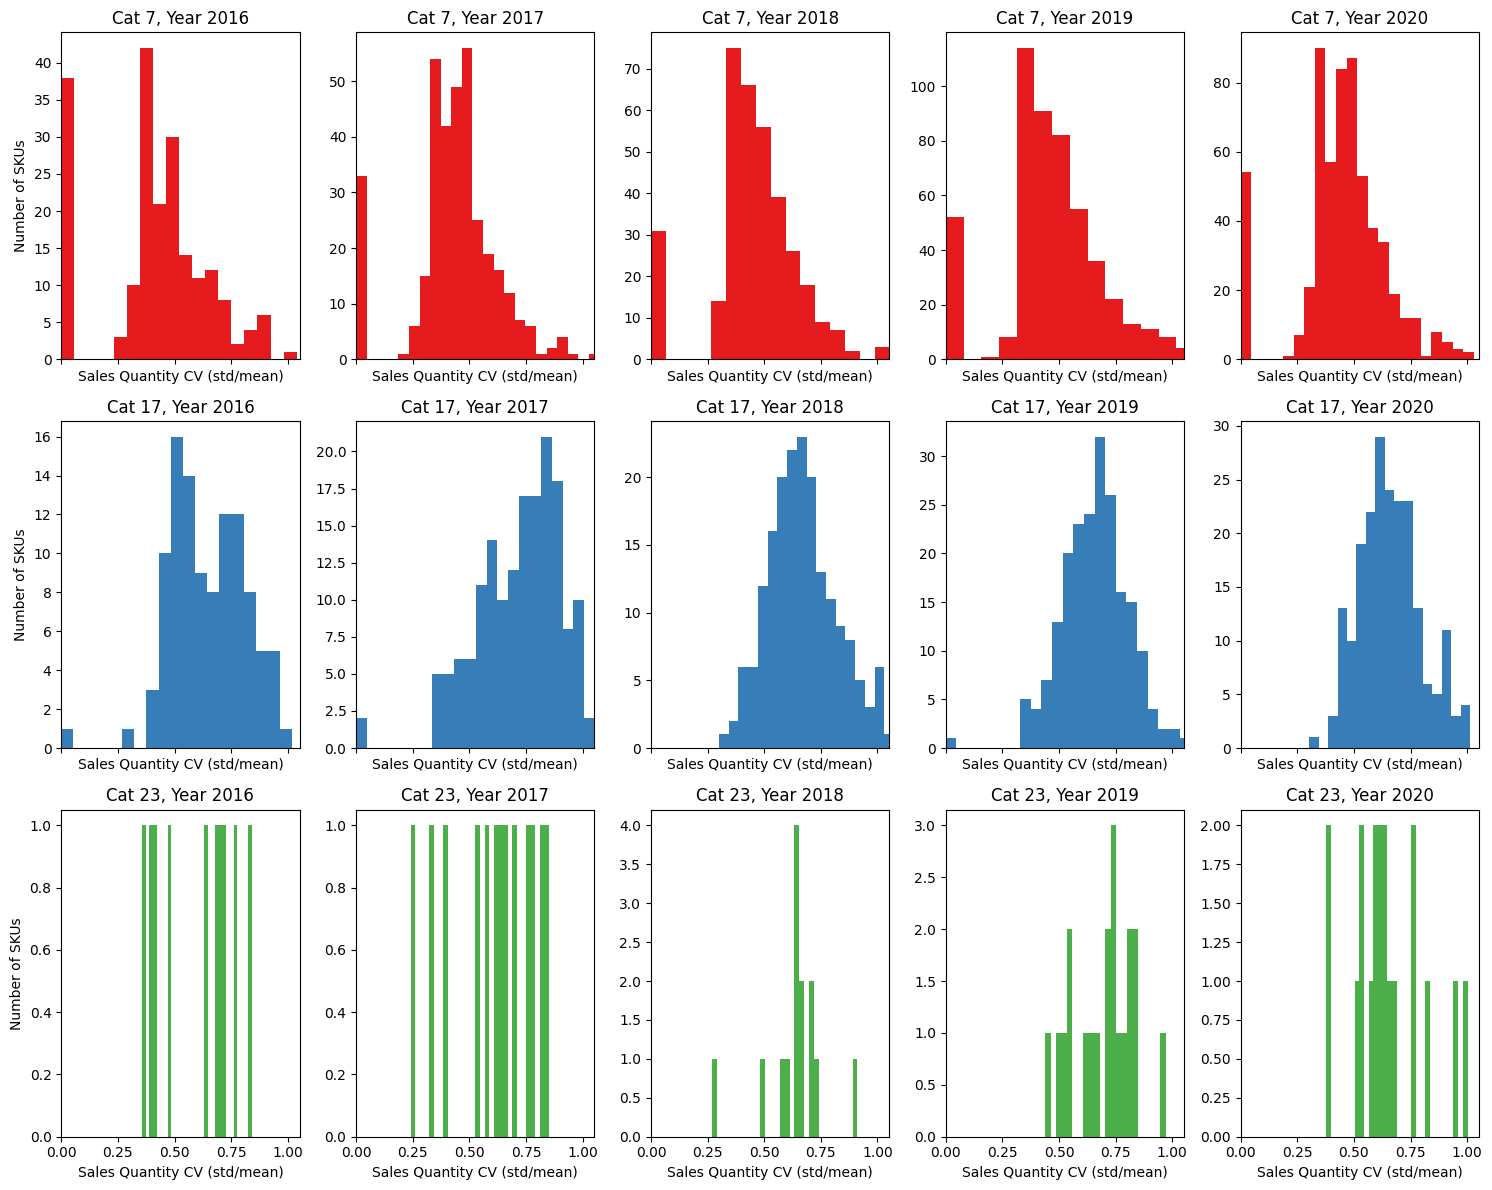

In [27]:
# Get all unique years and categories
years = sorted(df['year'].unique())
categories = sorted(df['category_id'].unique())

# Prepare color palette for categories
colors = sns.color_palette('Set1', n_colors=len(categories))
palette_dict = dict(zip(categories, colors))

# Prepare DataFrame to store all CV values
cv_cat_year = pd.DataFrame()

# Calculate CV for each SKU, year, and category
for cat in categories:
    for year in years:
        sub = df[(df['category_id'] == cat) & (df['year'] == year)]
        if sub.empty:
            continue
        means = sub.groupby('sku_id')['sales_quantity'].mean()
        stds = sub.groupby('sku_id')['sales_quantity'].std()
        cv = (stds / means).dropna()
        temp = pd.DataFrame({
            'cv': cv,
            'category_id': cat,
            'year': year,
            'sku_id': cv.index
        })
        cv_cat_year = pd.concat([cv_cat_year, temp], ignore_index=True)

# Plot
n_cat = len(categories)
n_years = len(years)
fig, axes = plt.subplots(n_cat, n_years, figsize=(3 * n_years, 4 * n_cat), sharey=False, sharex=True)

for i, cat in enumerate(categories):
    for j, year in enumerate(years):
        ax = axes[i, j] if n_cat > 1 else axes[j]
        data = cv_cat_year[(cv_cat_year['category_id'] == cat) & (cv_cat_year['year'] == year)]['cv'].sort_values()
        ax.hist(data, bins=30, color=palette_dict[cat])
        ax.set_title(f"Cat {cat}, Year {year}")
        ax.set_xlabel('Sales Quantity CV (std/mean)')
        ax.set_xlim(0, min(2, data.max()*1.05) if len(data) > 0 else 1)
        if j == 0:
            ax.set_ylabel('Number of SKUs')
plt.tight_layout()
plt.show()

- **Category 7 SKUs are "core" products with stable sales**
- **Category 17 has higher relative variability**
- **Category 23 is volatile (as we know it has very few products)**

## 3.4 Time series analysis

### 3.4.1 Data sparsity

In [28]:
print("Number of unique dates:")
df.date.nunique()

Number of unique dates:


1420

count    1059.000000
mean      213.867800
std       343.265784
min         1.000000
25%        15.000000
50%        64.000000
75%       209.500000
max      1416.000000
Name: num_records, dtype: float64


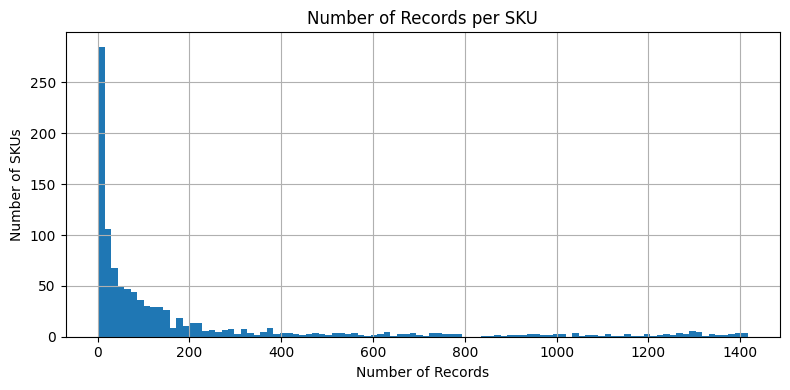

In [29]:
# Calculate the number of records per SKU
sku_num_records = df.groupby('sku_id').size().rename('num_records')

# Show basic stats
print(sku_num_records.describe())

# Plot histogram
plt.figure(figsize=(8, 4))
sku_num_records.hist(bins=100)
plt.title('Number of Records per SKU')
plt.xlabel('Number of Records')
plt.ylabel('Number of SKUs')
plt.tight_layout()
plt.show()

**Most SKUs have data for a small fraction of days (median = 64 out of 1,420 possible dates), while a few SKUs are present almost every day. We can make apply seperate approach for forecasting SKUs with few records.**

### 3.4.2 Average Quantity Over Categories 

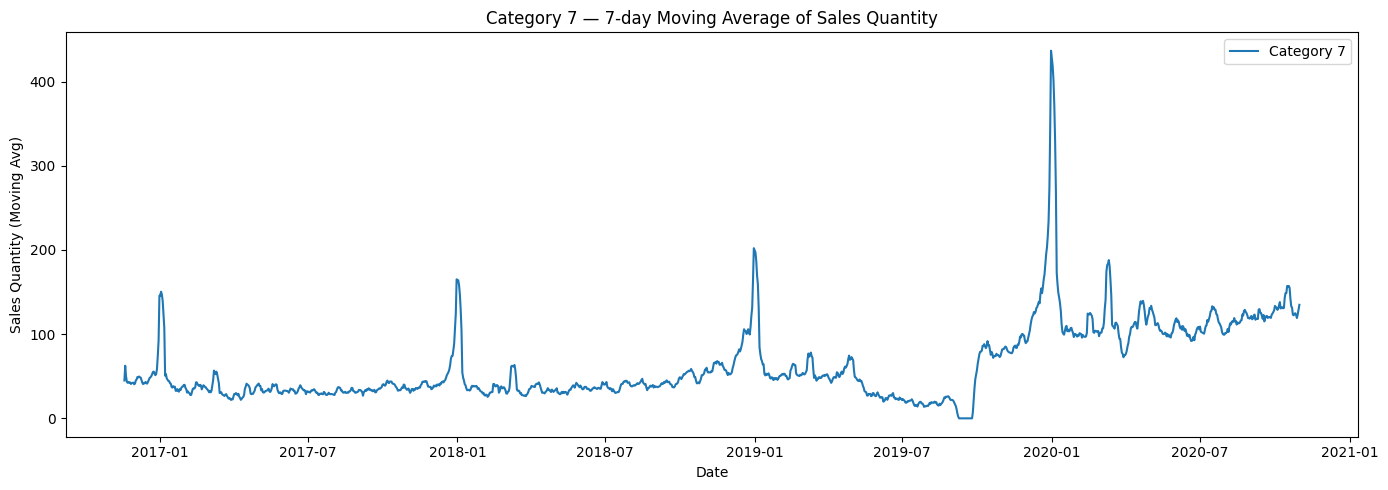

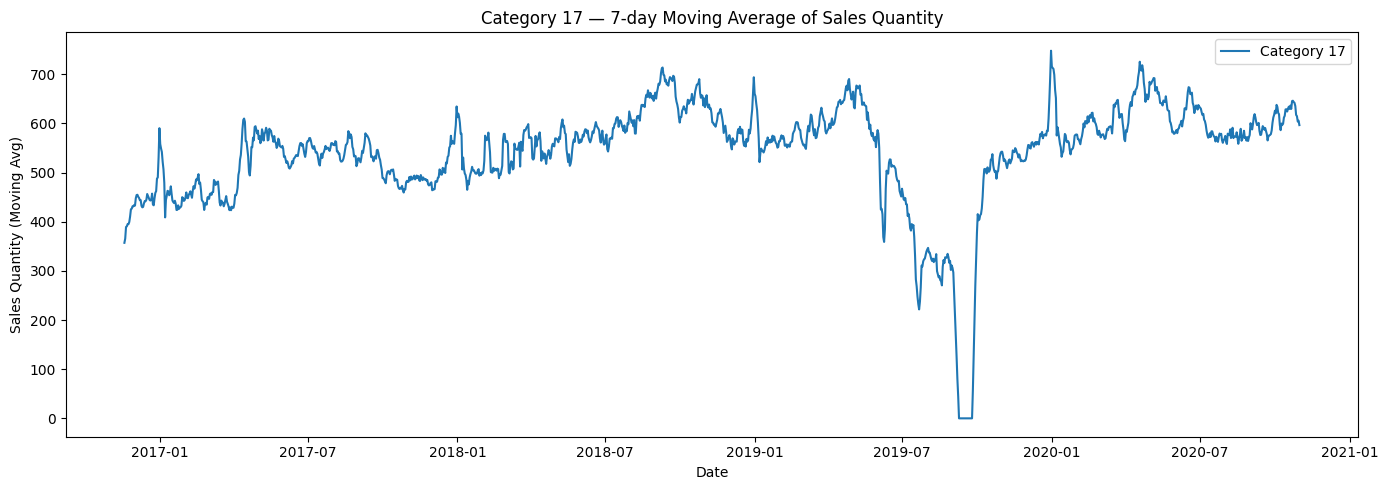

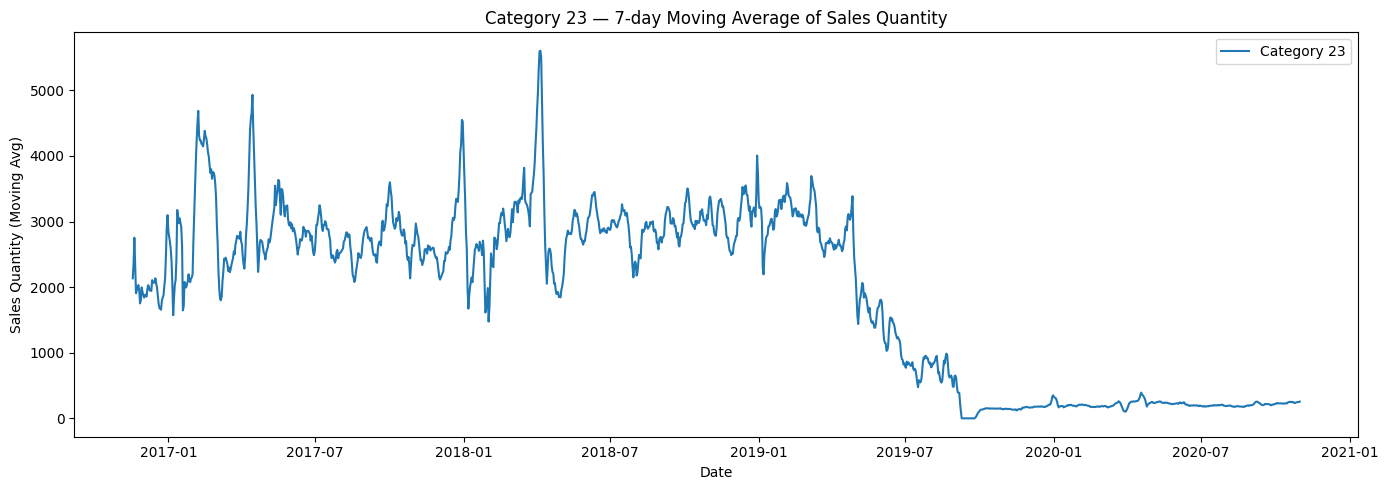

In [30]:
window = 7  # Moving average window in days
categories = sorted(df['category_id'].unique())

for cat in categories:
    plt.figure(figsize=(14, 5))
    df_cat = df[df['category_id'] == cat]
    all_dates = pd.date_range(df_cat['date'].min(), df_cat['date'].max(), freq='D')

    # Daily total sales for all SKUs in this category
    daily_sales = (
        df_cat.groupby('date')['sales_quantity']
        .sum()
        .reindex(all_dates, fill_value=0)
    )

    # Moving average
    sales_ma = daily_sales.rolling(window, min_periods=1).mean()

    plt.plot(sales_ma.index, sales_ma.values, label=f'Category {cat}')
    plt.title(f'Category {cat} — {window}-day Moving Average of Sales Quantity')
    plt.xlabel('Date')
    plt.ylabel('Sales Quantity (Moving Avg)')
    plt.legend()
    plt.tight_layout()
    plt.show()

- **Category 7 (expensive one) is really popular before New Year**.
- **Sales quantity for Category 23 has significant drop after 2019-09.**

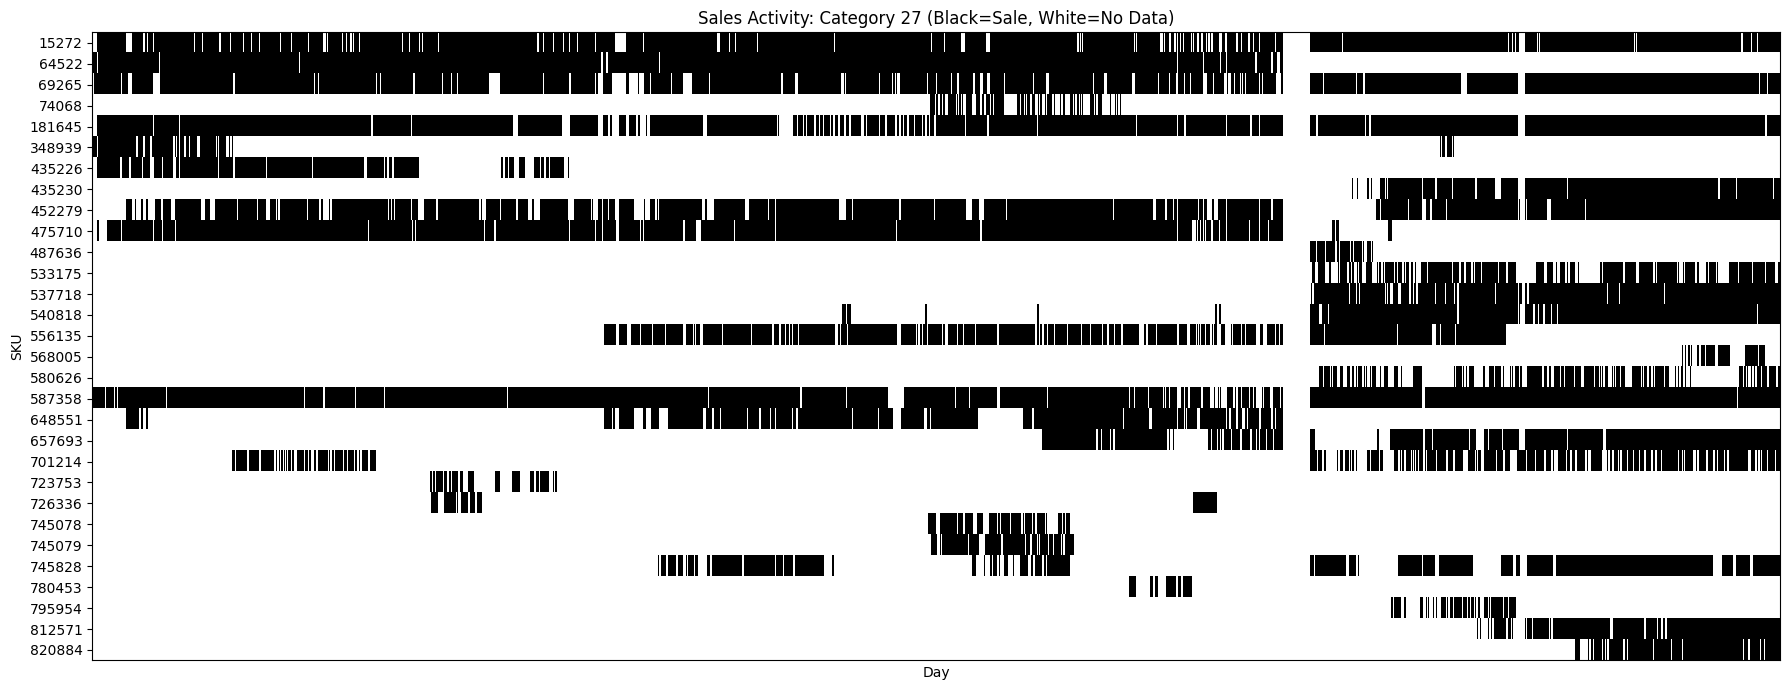

In [31]:
cat = 23

df_cat = df[df['category_id'] == cat]

# Get all SKUs and all possible dates for this category
skus = sorted(df_cat['sku_id'].unique())
all_dates = pd.date_range(df_cat['date'].min(), df_cat['date'].max(), freq='D')

# Build binary activity matrix: 1 if SKU sold on that day, 0 otherwise
activity_matrix = np.zeros((len(skus), len(all_dates)), dtype=int)
sku_to_idx = {sku: i for i, sku in enumerate(skus)}
date_to_idx = {date: i for i, date in enumerate(all_dates)}

for row in df_cat.itertuples():
    sku_idx = sku_to_idx[row.sku_id]
    date_idx = date_to_idx[row.date]
    activity_matrix[sku_idx, date_idx] = 1

plt.figure(figsize=(18, max(5, len(skus)//4)))
plt.imshow(activity_matrix, aspect='auto', cmap='Greys', interpolation='none')
plt.title('Sales Activity: Category 27 (Black=Sale, White=No Data)')
plt.xlabel('Day')
plt.ylabel('SKU')
plt.yticks(ticks=np.arange(len(skus)), labels=skus if len(skus) <= 50 else [])
plt.xticks([])
plt.tight_layout()
plt.show()

**We have a lot of new SKUs after 2019-09, also our super popular SKU id '64522' is missing.**

### 3.4.3 Weekday

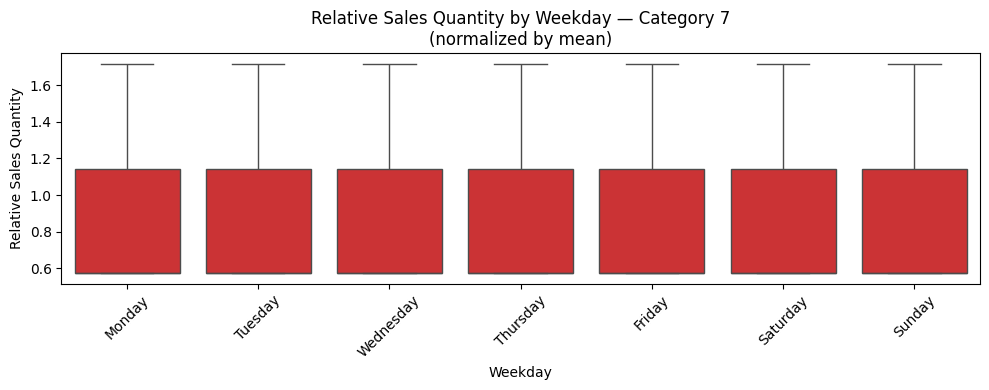

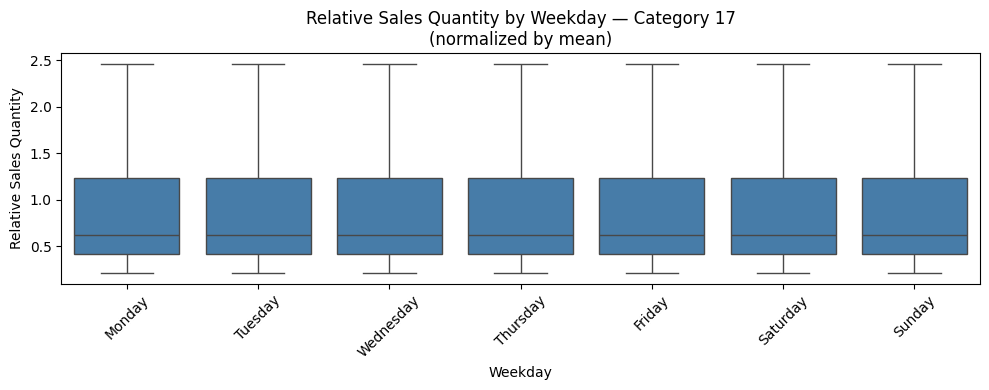

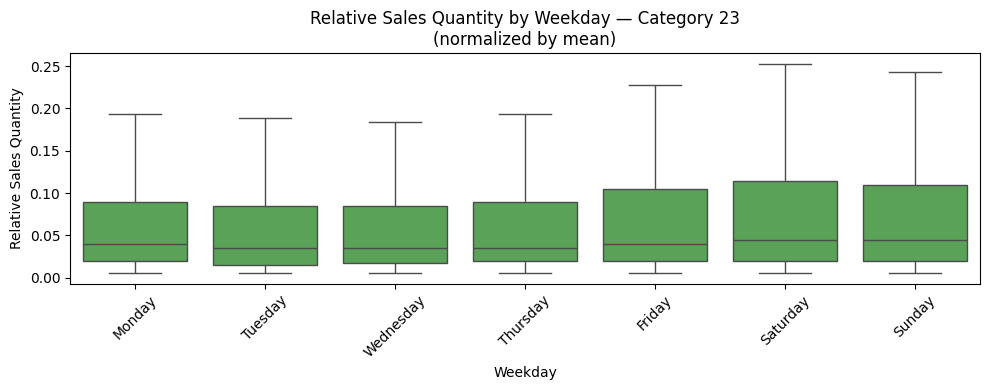

In [32]:
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
df['weekday'] = df['date'].dt.day_name()

for cat in categories:
    df_cat = df[df['category_id'] == cat].copy()
    mean_sales = df_cat['sales_quantity'].mean()
    df_cat['rel_sales_quantity'] = df_cat['sales_quantity'] / mean_sales
    
    plt.figure(figsize=(10, 4))
    sns.boxplot(
        x='weekday',
        y='rel_sales_quantity',
        data=df_cat,
        order=weekday_order,
        color=palette_dict[cat],
        showfliers=False
    )
    plt.title(f'Relative Sales Quantity by Weekday — Category {cat}\n(normalized by mean)')
    plt.xlabel('Weekday')
    plt.ylabel('Relative Sales Quantity')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

**No difference between weekdays, except Category 23 has higher sales after on Friday - Sunday.**

### 3.4.4 Holiday

In [33]:
# Add holiday column (+-1 day)

# Define years present in your data
years = range(df['date'].dt.year.min(), df['date'].dt.year.max() + 1)

# Get all official holidays for Ukraine in those years
ua_holidays = set(holidays.country_holidays('UA', years=years).keys())

# Expand to include ±1 day for each holiday
holiday_plus_minus_1 = set()
for day in ua_holidays:
    holiday_plus_minus_1.add(day - timedelta(days=1))
    holiday_plus_minus_1.add(day)
    holiday_plus_minus_1.add(day + timedelta(days=1))

# Mark as True if date is a holiday or adjacent day
df['is_holiday_or_adjacent'] = df['date'].dt.date.isin(holiday_plus_minus_1)

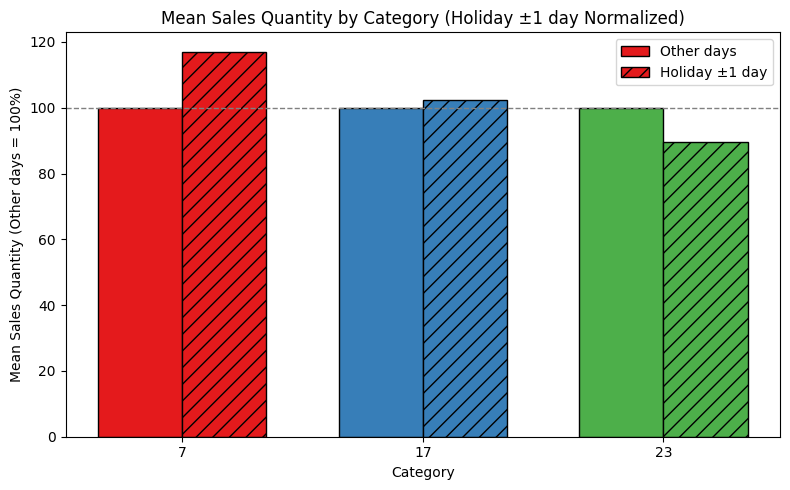

In [34]:
mean_df = (
    df.groupby(['category_id', 'is_holiday_or_adjacent'])['sales_quantity']
    .mean()
    .reset_index()
)

# Pivot for normalization
pivot_df = mean_df.pivot(index='category_id', columns='is_holiday_or_adjacent', values='sales_quantity')
pivot_df = pivot_df.rename(columns={False: 'Other days', True: 'Holiday ±1 day'})
pivot_df_norm = pivot_df.div(pivot_df['Other days'], axis=0) * 100

# Prepare for seaborn (long format)
plot_df_norm = pivot_df_norm.reset_index().melt(
    id_vars='category_id',
    value_vars=['Other days', 'Holiday ±1 day'],
    var_name='Period',
    value_name='Mean Sales Quantity (Other days = 100%)'
)

# Plot each category separately for custom colors/hatch
fig, ax = plt.subplots(figsize=(8, 5))

width = 0.35
x = np.arange(len(categories))

# Bars for "Other days"
bar1 = ax.bar(
    x - width/2,
    plot_df_norm[plot_df_norm['Period'] == 'Other days']['Mean Sales Quantity (Other days = 100%)'],
    width=width,
    color=[palette_dict[c] for c in categories],
    label='Other days',
    edgecolor='black'
)

# Bars for "Holiday ±1 day" with dashed hatch
bar2 = ax.bar(
    x + width/2,
    plot_df_norm[plot_df_norm['Period'] == 'Holiday ±1 day']['Mean Sales Quantity (Other days = 100%)'],
    width=width,
    color=[palette_dict[c] for c in categories],
    label='Holiday ±1 day',
    edgecolor='black',
    hatch='//'
)

ax.axhline(100, ls='--', color='gray', lw=1)
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.set_xlabel('Category')
ax.set_ylabel('Mean Sales Quantity (Other days = 100%)')
ax.set_title('Mean Sales Quantity by Category (Holiday ±1 day Normalized)')
ax.legend()
plt.tight_layout()
plt.show()

**Holidays and adjacent days strongly boost sales in Category 7, have a minimal positive effect in Category 17, and are associated with lower sales in Category 23.**

### 3.4.5 Top SKU

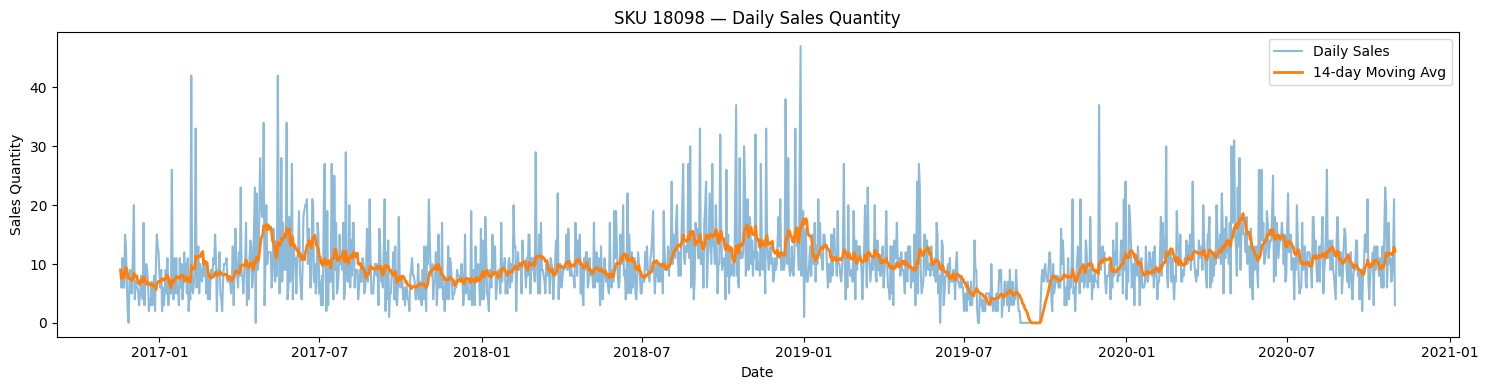

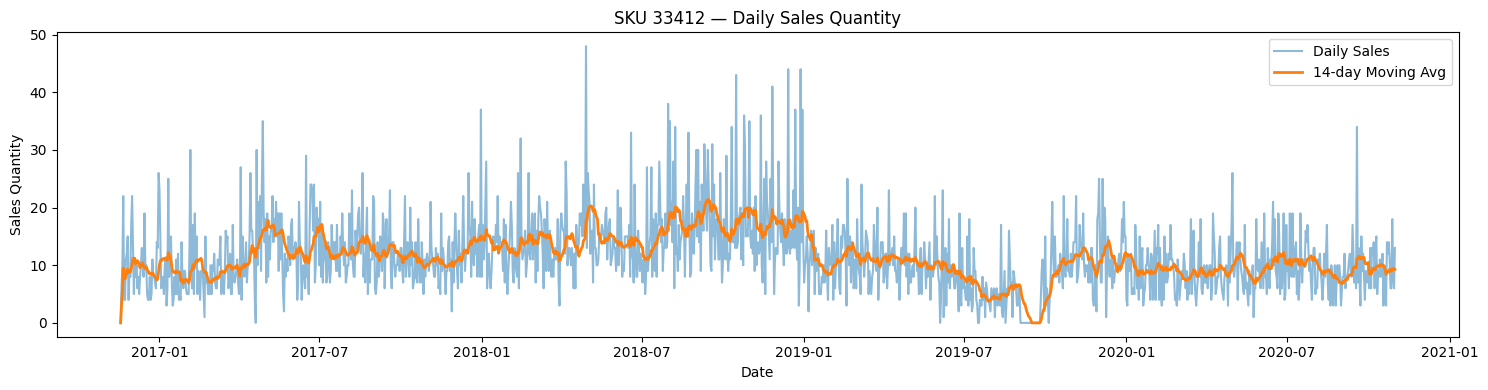

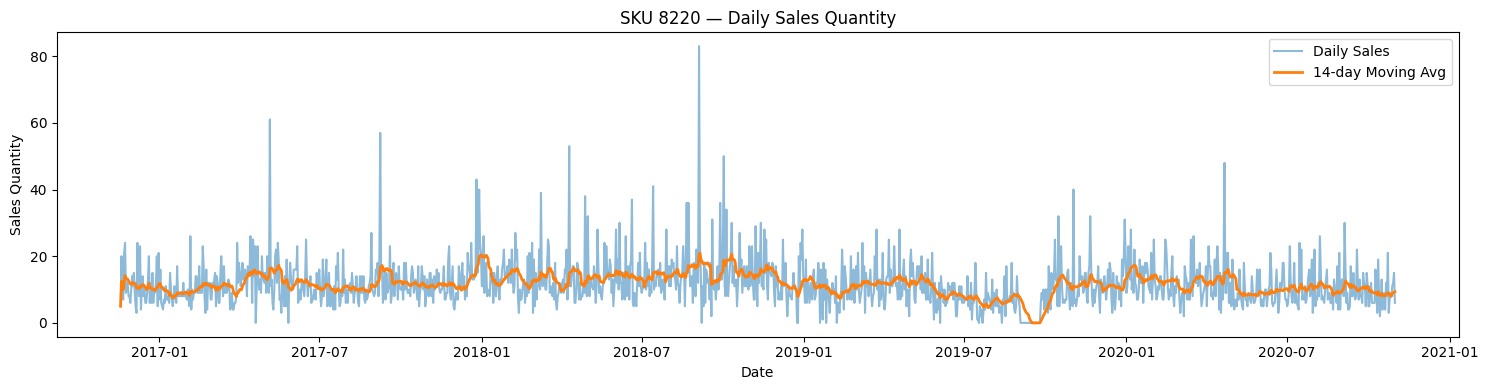

In [35]:
# Identify and plot top SKUs by presence (number of rows, i.e., days with sales)
sku_num_records = df.groupby('sku_id').size().sort_values(ascending=False)
top_n = 3  # or any other number you want
top_skus = sku_num_records.head(top_n).index.tolist()

all_dates = pd.date_range(df['date'].min(), df['date'].max(), freq='D')

window = 14
for sku in top_skus:
    sku_sales = (
        df[df['sku_id'] == sku]
        .groupby('date')['sales_quantity']
        .sum()
        .reindex(all_dates, fill_value=0)
    )
    sales_ma = sku_sales.rolling(window, min_periods=1).mean()
    
    plt.figure(figsize=(15, 4))
    plt.plot(sku_sales.index, sku_sales.values, label='Daily Sales', color='tab:blue', alpha=0.5)
    plt.plot(sales_ma.index, sales_ma.values, label=f'{window}-day Moving Avg', color='tab:orange', lw=2)
    plt.title(f'SKU {sku} — Daily Sales Quantity')
    plt.xlabel('Date')
    plt.ylabel('Sales Quantity')
    plt.legend()
    plt.tight_layout()
    plt.show()

**We should somehow handle this missing data for 2019-09: we can use 1 month lag**

Top SKU: 18098


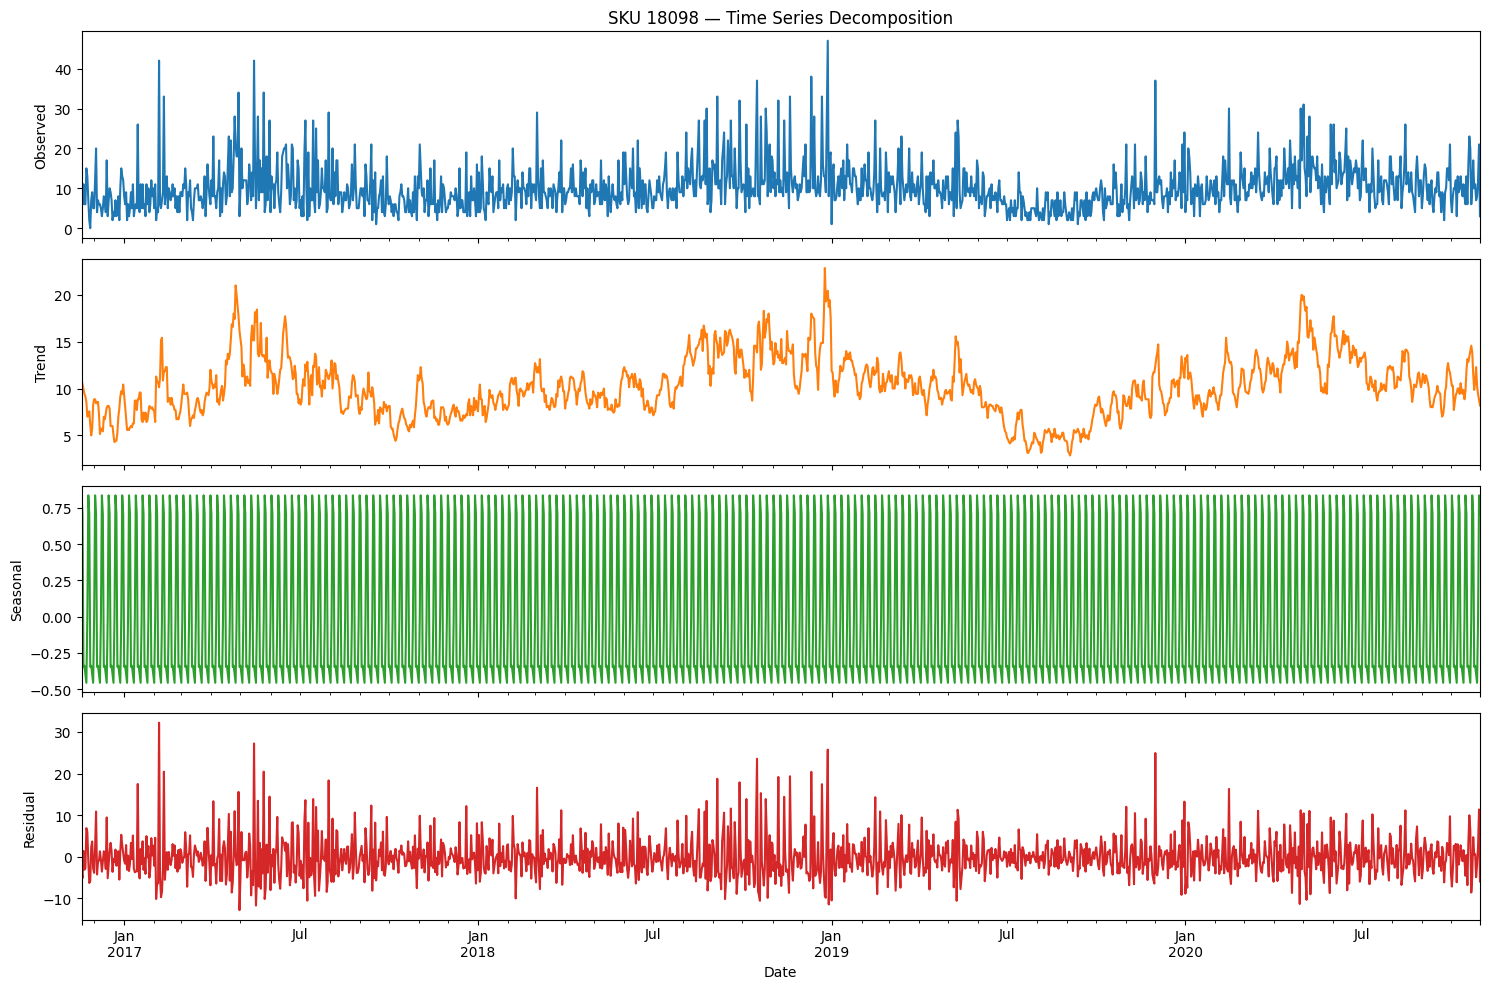

In [50]:
# Identify the top SKU by number of records
sku_num_records = df.groupby('sku_id').size().sort_values(ascending=False)
top_sku = sku_num_records.index[0]
print(f"Top SKU: {top_sku}")

# Create complete daily time series for this SKU
all_dates = pd.date_range(df['date'].min(), df['date'].max(), freq='D')
sku_df = df[df['sku_id'] == top_sku].copy()
sku_df = sku_df.set_index('date').sort_index()
sku_sales = sku_df['sales_quantity'].reindex(all_dates)
sku_sales.index.name = 'date'

# Fill missing values with value from 30 days before (lag=30)
lag = 30
sku_sales_filled = sku_sales.copy()
sku_sales_filled = sku_sales_filled.fillna(sku_sales_filled.shift(lag))

sku_sales_filled = sku_sales_filled.fillna(0)


result = seasonal_decompose(sku_sales_filled, model='additive', period=7, extrapolate_trend='freq')

fig, axes = plt.subplots(4, 1, figsize=(15, 10), sharex=True)
result.observed.plot(ax=axes[0], color='tab:blue')
axes[0].set_ylabel('Observed')
axes[0].set_title(f"SKU {top_sku} — Time Series Decomposition")
result.trend.plot(ax=axes[1], color='tab:orange')
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], color='tab:green')
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], color='tab:red')
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Date')
plt.tight_layout()
plt.show()

**Substantial part of the variance remains unexplained by simple trend/seasonality**.

### 3.4.6 Correlation between SKUs

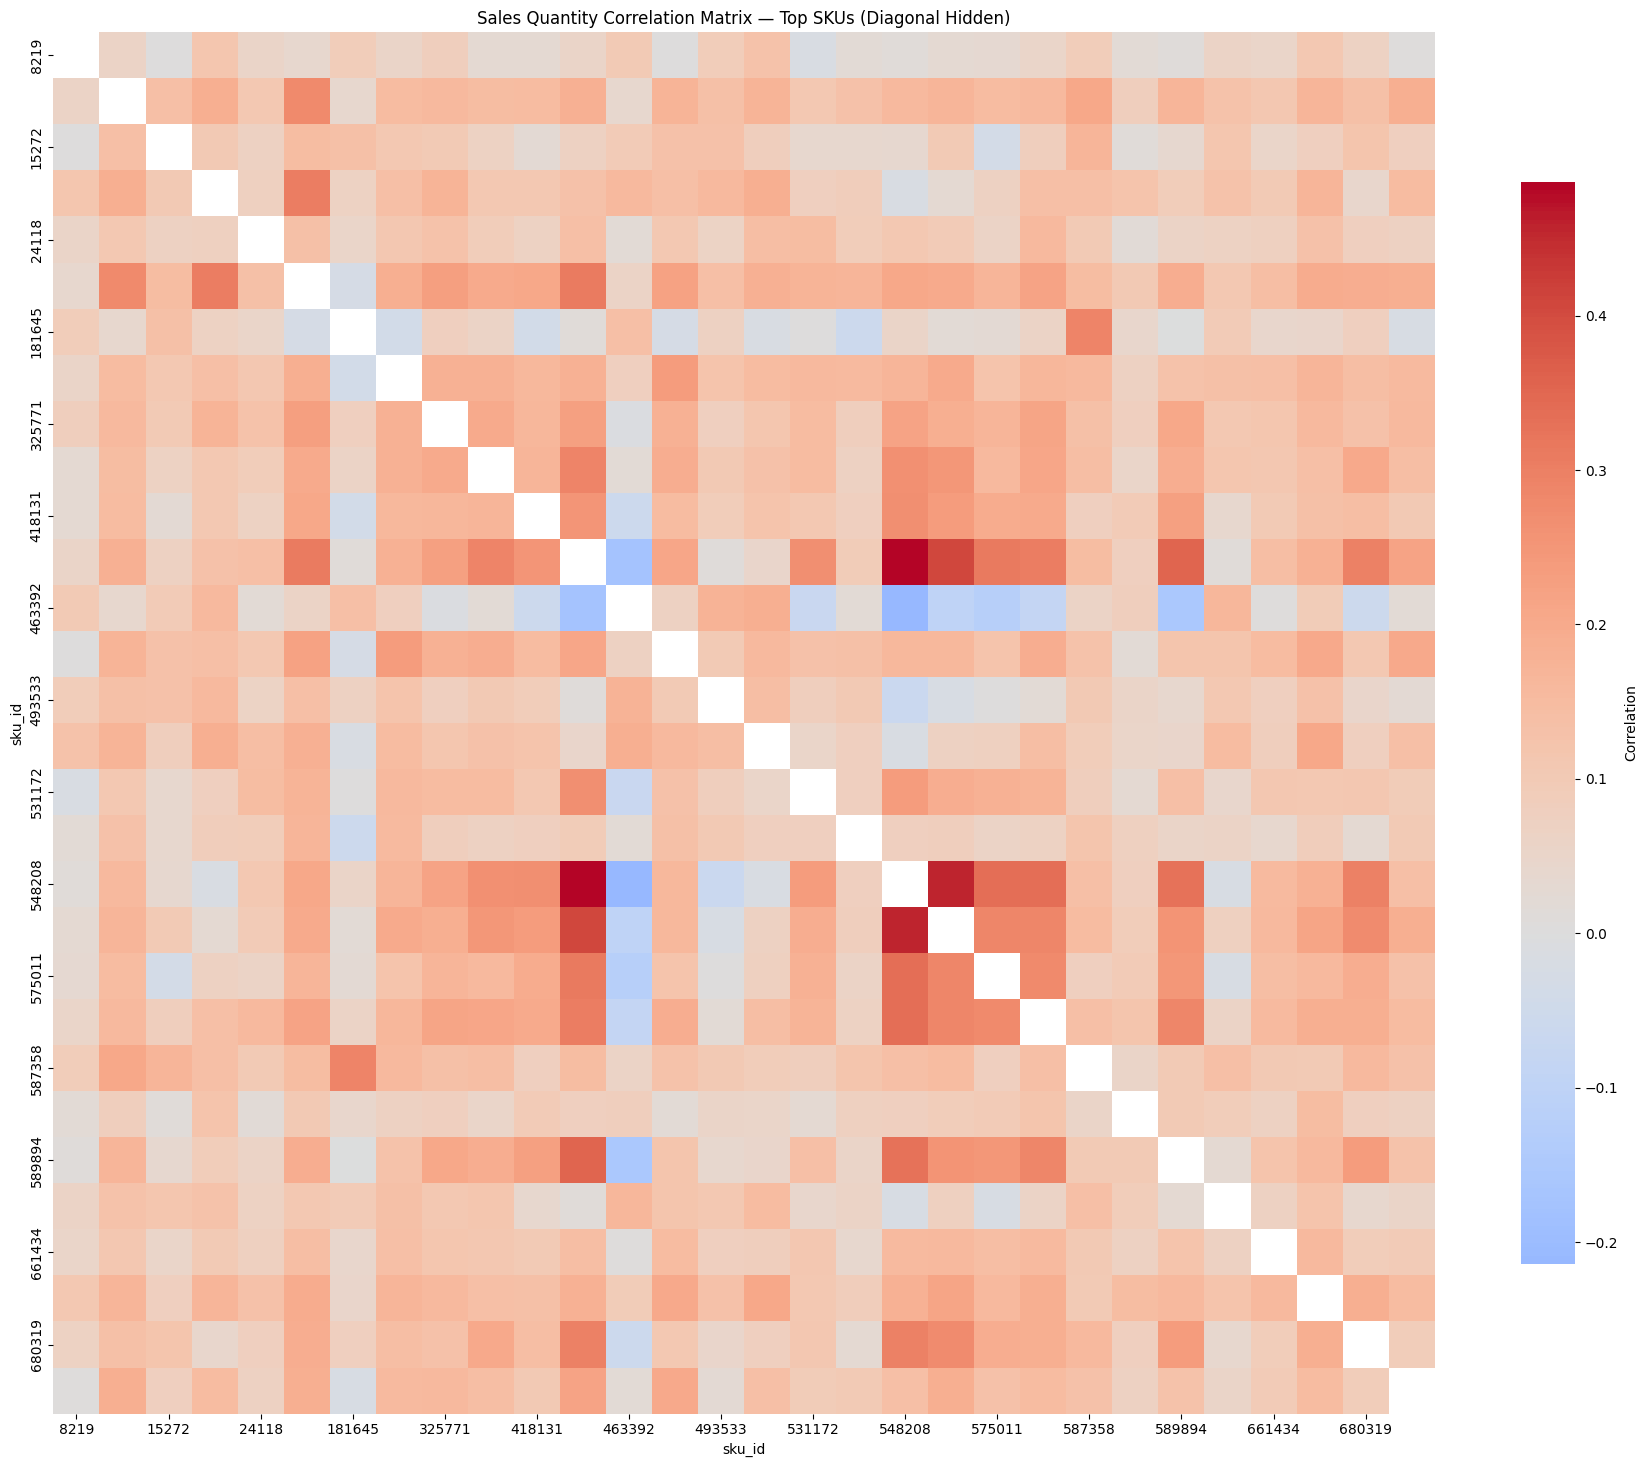

In [58]:
# Select top SKUs by number of records (days with sales)
sku_num_records = df.groupby('sku_id').size().sort_values(ascending=False)
top_100_skus = sku_num_records.head(30).index

# Get all possible dates in the dataset
all_dates = pd.date_range(df['date'].min(), df['date'].max(), freq='D')

# Pivot the data: each column is an SKU, each row is a date, values are sales_quantity
sales_matrix = (
    df[df['sku_id'].isin(top_100_skus)]
    .pivot_table(index='date', columns='sku_id', values='sales_quantity', fill_value=0)
    .reindex(all_dates)
    .fillna(0)
)

corr_matrix = sales_matrix.corr()
mask = np.eye(len(corr_matrix), dtype=bool)
plt.figure(figsize=(18, 15))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    square=True,
    mask=mask,
    cbar_kws={"shrink": .75, "label": "Correlation"},
    xticklabels=2,
    yticklabels=2
)
plt.title('Sales Quantity Correlation Matrix — Top SKUs (Diagonal Hidden)')
plt.tight_layout()
plt.show()

**Sales of top SKUs are mostly uncorrelated with each other. Few SKUs has relative correlation (around 0.5)**

### 4 Key findings

**Data Quality and Structure:**
- There are 3 categories and 1059 SKUs: each (date, sku_id) combination appears at most once: no duplicate sales records per day per SKU.
- Most SKUs are highly sparse, with a median of only 64 days of recorded sales (out of 1,420+ possible), while a few "core" SKUs are present almost daily.
- **No data for September 2019 – we don't know if is problem with dataset, or shop was closed.**


**Univariate Distributions:**
- Sales Quantity: extremely right-skewed, most sales events are of small size (1–5 units), with very few high-quantity outliers (>100 units, ~0.5% of records, one SKU).
- Sales Price: multi-modal, reflecting distinct price bands by category. Some categories consistently operate at much higher prices than others.

**Category-Level Differences:**
- Category 7: High-priced, low-quantity “core” products, with strong seasonality (especially before New Year and holidays).
- Category 17: Mid-range for both price and quantity, showing steady growth over years and moderate response to seasonality.
- Category 23: Lower price, higher quantity, but much fewer products and much higher volatility; sharp drop in sales after 2019-09.


**Calendar Effects:**
- Seasonality: weekly patterns are present but not dominant for most SKUs. Sales in Category 23 are elevated on weekends (Friday–Sunday); other categories have minimal weekday effects.
- Holiday Effects: national holidays and adjacent days strongly boost sales in Category 7, have a moderate or minimal positive effect for Category 17, and lower sales for Category 23.

**SKU-Level Patterns:**
- A single SKU (64522) dominates high-quantity sales and should be considered for separate modeling or special treatment.
- Most SKUs have stable prices within a year (max/min ratio usually <1.5), with few outliers.
- Top SKUs have weak correlation.